<a href="https://colab.research.google.com/github/Jheim12/PPHA30456/blob/main/lab_03/ML_lab3_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Classification - OLS, Logistic, LDA, QDA & KNN

This notebook has been designed to enable you to practice with LDA, QDA and KNN classifiers. You will also learn how to perform the validation set approach to estimate the test error.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

## 0. Load, understand, and wrangle the data

We will be using the [Wisconsin Breast Cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) dataset and try to predict whether a tumor is benign or malignant. In addition to whether the patient was diagnosed with a benign (B) or malignant (M) tumor, the dataset contains a set of features that describe characteristics of the cell nuclei present in the image.

In [2]:
# Load the data
data = pd.read_csv("https://raw.githubusercontent.com/Jheim12/PPHA30456/main/lab_03/data.csv")
print(data.shape)
data.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


To simplify the example, we'll only take the first 10 features randomly. Of course, you would usually select the 10 most powerful features rather than randomly selecting them.

In [3]:
# Select the target and the first 10 features
data = data.iloc[:,1:12]

display(data.head())
print(data.shape)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


(569, 11)


All (supervised) `scikit-learn` models take the target and features as distinct inputs. Hence, we separate the data into X and y.

In [4]:
# Sort our target and features into different dataframes
X = data.drop(['diagnosis'], axis = 1)
y = data['diagnosis']

# Target categories frequency
y.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

We convert our label to binary values. It is good practice to rename the column name as well to avoid any confusion, but pandas series do not have a name so we can omit this step.

- Benign → 0
- Malignant → 1

In [5]:
# Convert to categorical before encoding
y = data['diagnosis'].astype('category').cat.codes

# Also perform sanity checks!
print(y.value_counts())

# Check the encoding
print(dict(enumerate(data['diagnosis'].astype('category').cat.categories)))

0    357
1    212
dtype: int64
{0: 'B', 1: 'M'}


We now have successfully loaded and wrangled our data into our input dataframes (X, y) and can move on with the train-test split.

## 1. Divide your dataset into train and test

Can't forget this! This is the only way to get a reliable estimate of your model's performance.

In [6]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Sanity check... Double check that the index of the train and test sets match
display(X_train.head(), X_test.head(), y_train.head(), y_test.head())

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
149,13.74,17.91,88.12,585.0,0.07944,0.06376,0.02881,0.01329,0.1473,0.05580
124,13.37,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.02800,0.1422,0.05823
421,14.69,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,0.2086,0.07406
195,12.91,16.33,82.53,516.4,0.07941,0.05366,0.03873,0.02377,0.1829,0.05667
545,13.62,23.23,87.19,573.2,0.09246,0.06747,0.02974,0.02443,0.1664,0.05801


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782


149    0
124    0
421    0
195    0
545    0
dtype: int8

204    0
70     1
131    1
431    0
540    0
dtype: int8

It is good practice to make sure that our train and test sets are balanced. This means making sure that there are no significant differences between them. For this, we will merge the datasets back together while adding a dummy variable indicating whether a row comes from the training or the test set. We can then use this dummy variable as the independent variable in a regression and evaluate the p-values of all features.

Note that we only need to do this on the features. For the targets, you simply want to make sure that the labels are relatively well distributed among the train and test set.

In [7]:
# Insert the dummy variable in each set
X_train.insert(0, 'test', 0)
X_test.insert(0, 'test', 1)

# Merge the train and test set
X_full = pd.concat([X_test, X_train], axis = 0)

display(X_full)
print(X_full['test'].value_counts())

,test,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
204,1,12.470,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,0.1925,0.06373
70,1,18.940,21.31,123.60,1130.0,0.09009,0.10290,0.10800,0.07951,0.1582,0.05461
131,1,15.460,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796
431,1,12.400,17.68,81.47,467.8,0.10540,0.13160,0.07741,0.02799,0.1811,0.07102
540,1,11.540,14.44,74.65,402.9,0.09984,0.11200,0.06737,0.02594,0.1818,0.06782
...,...,...,...,...,...,...,...,...,...,...,...
71,0,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980
106,0,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520
270,0,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376
435,0,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544


0    398
1    171
Name: test, dtype: int64


What we essentially did was add the train set to the bottom of the test set. Notice how the index is all shuffled, which is a result of the randomization of the train-test-split.

Now, we can simply run a regression with `test` as the independent variable being predicted by all the features.

In [8]:
result = smf.ols(
    'test ~ radius_mean + texture_mean + perimeter_mean + area_mean + smoothness_mean + compactness_mean + concavity_mean + symmetry_mean + fractal_dimension_mean',
    data = X_full
).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   test   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.5553
Date:                Fri, 27 Jan 2023   Prob (F-statistic):              0.834
Time:                        14:45:34   Log-Likelihood:                -361.12
No. Observations:                 569   AIC:                             742.2
Df Residuals:                     559   BIC:                             785.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

All of the p-values are larger than 0.1, hence, we can conclude that the train and test set are not significantly different (i.e., that they are very similar). This is exactly what we wished for. Otherwise, a model trained on the training set would not be able to predict the test set well.

With the labels, it is often sufficient to compute the percentage of positive labels (i.e., percentage of malignant) and see if this ratio is approximately equal. In this case, it is true.

In [9]:
# Check the label distribution in the training and test sets
print(f'Percentage of positive labels in the test set: {round(y_test.mean()*100, 2)}')
print(f'Percentage of positive labels in the training set: {round(y_train.mean()*100, 2)}')

Percentage of positive labels in the test set: 36.84
Percentage of positive labels in the training set: 37.44


Of course, the larger the sample and the more balanced it is, the less likely we are to run into issues here. Hence, if you have small sample and/or variables with some "outliers" (in the sense that there are only few observations with values in a rare range), you should take this step very seriously.

Anyways, now that we have made sure that our train-test split is of good quality in the sense that none of our features are significantly correlated to the 'test' dummy (i.e., being in a test or train set), we can remove it again.

In [10]:
# Remove the test dummy
X_test = X_test.drop(['test'], axis = 1)
X_train = X_train.drop(['test'], axis = 1)

## 2. Good old OLS


Since the models we discuss were developed to outperform the OLS model when predicting categorical (i.e., classification), it is useful to see how it does to set a benchmark.

In [11]:
# Define and train the OLS model
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

# Predict the labels on the test set
y_pred_ols = model.predict(X_test)

Of course, one problem of using OLS for classification is that its predictions will not necessarily lie between 0 and 1.

In [12]:
# 10 first predictions
y_pred_ols[:10]

array([0.2545099 , 0.78391203, 0.7383423 , 0.10432796, 0.03194086,
       1.56782097, 1.34188845, 0.64738314, 0.58479897, 0.05768623])

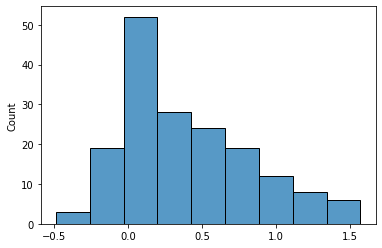

In [13]:
# Histogram of the predictions
sns.histplot(y_pred_ols)

To turn those continuous predictions into binary ones, we can use a threshold. Here, we will use the somewhat arbitrary threshold of 0.7 above which we will classify an observation as malignant (M) and below it as benign (B).

In [14]:
# Continuous to binary predictions
y_pred_ols_bin = np.where(y_pred_ols > 0.7, 1, 0)

y_pred_ols_bin[:10]

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0])

The accuracy score is the gold standard of performance measurement of classification models. Essentially, it measures which percentage of labels were correctly predicted by the model:

$$ Accuracy\ Score = \frac{Nb.\ Correct\ Predictions}{Nb.\ Total\ Predictions} $$

Whether or not the accuracy score of a model is good or not depends on the baseline. The baseline is simply the frequency of the label occurring the most in the test set. Hence, we compare the accuracy of a model to always guessing the most common label. If our model is not able to outperform this, it is literally counterproductive.

In [15]:
# Initialize accuracy tracking dictionary
accuracies = {} 

# Computing the baseline accuracy
accuracies['baseline'] = round(y_test.value_counts().max()/len(y_test), 2)

# Compute the accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
accuracies['OLS'] = accuracy_score(y_test, y_pred_ols_bin)

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

# The baseline is indeed the accuracy of guessing the most frequent label
print(
    round(
        accuracy_score(
            y_test,
            pd.Series([y_test.value_counts().idxmax()]*len(y_test))
        )
    , 2)
)

baseline accuracy: 63.0%
OLS accuracy: 88.3%
0.63


We are also interested to see if there are certain categories that are harder to predict for the model. A confusion matrix gives us a pretty good idea on whether that is the case for a particular model.

![ConfusionMatrix.png](ConfusionMatrix.png)

In [16]:
cm_ols = confusion_matrix(y_test, y_pred_ols_bin, normalize = 'true')
print(cm_ols)

[[1.         0.        ]
 [0.31746032 0.68253968]]


This display of the confusion matrix is obviously not very digestible. Let's make a heatmap out of it!

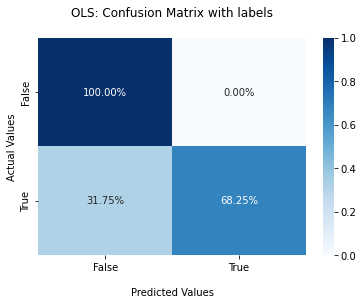

In [17]:
ax = sns.heatmap(cm_ols, annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('OLS: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

We see that the model predicts all (actual) benign (False) correctly. However, it performs less good on (actual) malignant (True) observations that it often (wrongly) predicts as benign.

As the plot below shows, this is not surprising  as the threshold of 0.7 is above any predicted (continuous) probability by OLS for (actual) benign (False) observations.

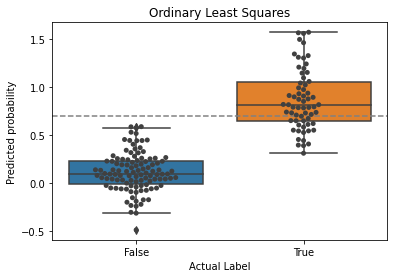

In [18]:
# Visualize with a box/swarmplot
ax = sns.boxplot(x=y_test, y=y_pred_ols)
ax = sns.swarmplot(x=y_test, y=y_pred_ols, color = ".25")
ax.axhline(0.7, ls = '--', color = 'grey')
ax.xaxis.set_ticklabels(['False','True'])
ax.set_xlabel('Actual Label')
ax.set_ylabel('Predicted probability')
ax.set_title('Ordinary Least Squares')
plt.show()

We know that OLS is not well-suited for classification problems, so how do the other models perform? Let's see!

## 3. Logistic Regression

A logistic regression has the advantage of predicting probabilities within 0 and 1.

$$ p(x) = \frac{1}{1 + e^{-(x-\mu)/s}} = \frac{1}{1 + e^{-(\beta_{0} + \beta_{1}x)}} \in [0, 1] $$

Where:

- $\beta_{0} = -\mu/s$
- $\beta_{1} = 1/s$

Notice that $p(\mu)=1/2$

In [19]:
# Fit the model
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

# Predict the test set
y_pred_log = logisticRegr.predict(X_test)
y_pred_log_proba = logisticRegr.predict_proba(X_test)
display(y_pred_log[:5])
display(y_pred_log_proba[:5])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 1, 1, 0, 0], dtype=int8)

array([[0.8770216 , 0.1229784 ],
       [0.00510184, 0.99489816],
       [0.24264819, 0.75735181],
       [0.88331609, 0.11668391],
       [0.97148545, 0.02851455]])

Notice that the logistic regression predicts the probabilities of an observation belonging to each class. Those probabilities hence sum up to 1 for each observation.

As expected, when plotting the likelihood of a tumor being malignant, we see that we now have probabilities that are bounded between 0 and 1. Additionally, we can see that the low and high probabilities are much more common than the mid-range probabilites. This is good as it means that we don't have to make any "close" decisions.

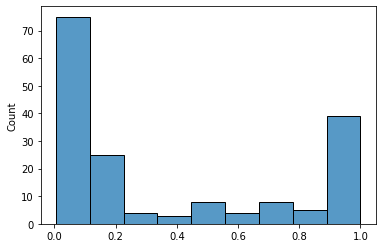

In [20]:
# Binary classification, so we only need one probability
y_pred_log_proba = y_pred_log_proba[: ,1]

sns.histplot(y_pred_log_proba)

In [21]:
# Compute the accuracy
accuracies['logit'] = accuracy_score(y_test, logisticRegr.predict(X_test))

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

baseline accuracy: 63.0%
OLS accuracy: 88.3%
logit accuracy: 93.57%


Looking at the heatmap again, we notice that the logistic regression is also predicting the (actually) benign (False) mostly correctly and is doing slightly better on the (actually) malignant (True) than OLS. Hence, the accuracy improvement is coming from there.

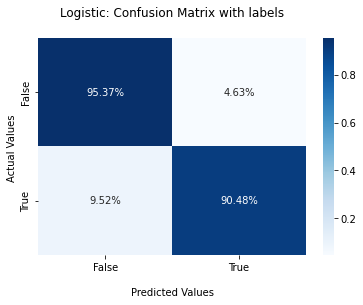

In [22]:
# Confusion Matrix
ax = sns.heatmap(
    confusion_matrix(
        y_test,
        logisticRegr.predict(X_test),
        normalize = 'true'
    ),
    annot=True, 
    fmt='.2%',
    cmap='Blues'
)

# Title and Labels
ax.set_title('Logistic: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

# Display the visualization of the Confusion Matrix.
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


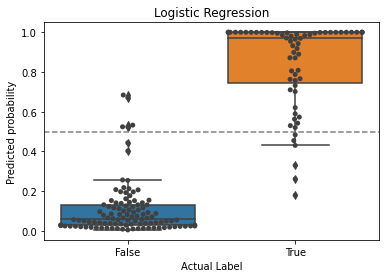

In [23]:
# Visualize with a box/swarmplot
ax = sns.boxplot(x=y_test, y=y_pred_log_proba)
ax = sns.swarmplot(x=y_test, y=y_pred_log_proba, color = ".25")
ax.axhline(0.5, ls = '--', color = 'grey')
ax.xaxis.set_ticklabels(['False','True'])
ax.set_xlabel('Actual Label')
ax.set_ylabel('Predicted probability')
ax.set_title('Logistic Regression')
plt.show()

To better understand how the logistic regression works, let's consider a small model with only 2 features, which allows us to make a 2D plot.

More precisely, we will use a the `radius_mean` and `texture_mean` features while the actual labels is defined by the color of the observations. The shaded areas represent the predicted classes (we use the standard p(x) = 0.5 threshold here for illustration purposes).

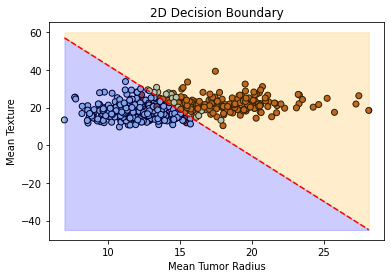

In [24]:
# Fit the mini-model
f1 = 'radius_mean'
f2 = 'texture_mean'


mini_X = X[[f1, f2]]
model = LogisticRegression()
model.fit(mini_X, y)

b = model.intercept_[0]
w1, w2 = model.coef_.T

# Scatter the actual labels
plt.scatter(
    mini_X[f1].values,
    mini_X[f2].values,
    c=y,
    edgecolors='k',
    cmap=plt.cm.Paired
)

# Some linear algebra
c = -b/w2
m = -w1/w2
xmin, xmax = mini_X[f1].min(), mini_X[f1].max()
ymin, ymax = -45, 60
xd = np.array([xmin, xmax])
yd = m*xd + c

# Lineplot the decision boundary
plt.plot(xd, yd, '--', c="red")

# Shade the prediction areas
plt.fill_between(xd, yd, ymin, color='blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='orange', alpha=0.2)

# Labels
plt.xlabel('Mean Tumor Radius')
plt.ylabel('Mean Texture')
plt.title('2D Decision Boundary')

plt.show()

Here, we can perfectly see how the logistic regression works and that those two features already seem to classify the observations quite well.

Notice how the decision boundary separates the space. At a conceptual level, this doesn't have with more features (with 3 features, a plane will divide a 3D space, etc.).

## 4. Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis is also a way to model categorical outcome variables, but takes a different approach than the logistic regression.

While logistic regressions model the probability of success directly $(P(y=k|X))$, LDA models it indirectly $(P(X|Y=k))$ via Bayes' theorem.

LDA requires more assumptions than logistic regressions, but LDA works better than logit if they are met:
- Classes are well separated
- N is small
- Distribution of X is approximately normal

In [25]:
# Fit the LDA model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

LDA also has a high accuracy, but it doesn't necessarily perform better than logit.

In [26]:
# Compute the accuracy
y_pred = lda_model.predict(X_test)
accuracies['LDA'] = accuracy_score(y_test, y_pred)

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

baseline accuracy: 63.0%
OLS accuracy: 88.3%
logit accuracy: 93.57%
LDA accuracy: 93.57%


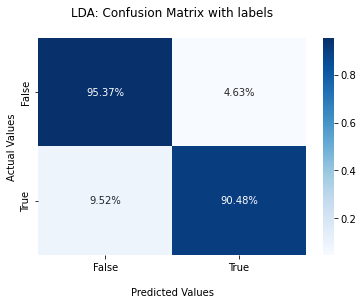

In [27]:
# Confusion Matrix
ax = sns.heatmap(
    confusion_matrix(
        y_test,
        y_pred,
        normalize = 'true'
    ),
    annot=True,
    fmt='.2%',
    cmap='Blues'
)

ax.set_title('LDA: Confusion Matrix with labels\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()


## 5. Quadratic Discriminant Analysis (QDA)

LDA assumes that every class has the same variance/covariance, which might lead to poor performance if that assumption is untrue.

Quadratic Discriminant Analysis works the same as LDA, but it estimates separate variance/covariance for each class.

In [28]:
# Fit the QDA model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [29]:
# Compute the accuracy
y_pred_q = qda_model.predict(X_test)
accuracies['QDA'] = accuracy_score(y_test, y_pred_q)

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

baseline accuracy: 63.0%
OLS accuracy: 88.3%
logit accuracy: 93.57%
LDA accuracy: 93.57%
QDA accuracy: 94.15%


Don't let the fact that our logit, LDA, and QDA model perform almost equally well, that there are potentially large differences. It all depends on the data and how well it is suited for each type of classification model.

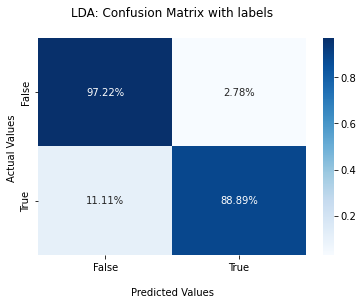

In [30]:
import matplotlib.pyplot as plt

ax = sns.heatmap(
    confusion_matrix(
        y_test,
        y_pred_q,
        normalize = 'true'
    ),
    annot=True, 
    fmt='.2%',
    cmap='Blues'
)

ax.set_title('LDA: Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

A final note on the confusion matrix. Ideally, we would want to correctly predict all observations correctly, however, that is rarely the case.

Sometimes, one wants to avoid false negatives more than false positives or vice-versa. Then, one can manipulate the probability threshold required to classify an observation into a category over another, but that will often require an accuracy tradeoff.

For instance, we could imagine that we want to avoid predicting a (actually) malignant tumor as benign. Then, you could set the required probability to classify an observation as benign to 80% for example (and maybe even create a new "unsure" category).

## 6. K-Nearest-Neighbor

KNN classification takes an entirely different approach than the models we saw previously. Luckily, it is very intuitive as a new observation is classified as the class winning the majority vote among the training observation.

However, with KNN we need to specify several important parameters:

- **k:** The number of neighbors
- **weights:** Votes weighted by distance?
    - **metric:** Metric to use to compute the distance

Let's start with a fairly straight-forward model that uses 5 unweighted neighbors to perform the majority vote.

In [31]:
# KNN with 5 neighbors
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights = 'uniform'
    )
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

Our KNN model performs a little worse than the ones we saw previously. However, we might be able to improve it by manipulating the parameters.

In [32]:
# Compute the accuracy
y_pred = knn_model.predict(X_test)
accuracies['KNN'] = accuracy_score(y_test, y_pred)

# Print the accuracies
for model, accuracy in accuracies.items():
    print(f'{model} accuracy: {round(accuracy, 4)*100}%')

baseline accuracy: 63.0%
OLS accuracy: 88.3%
logit accuracy: 93.57%
LDA accuracy: 93.57%
QDA accuracy: 94.15%
KNN accuracy: 90.06%


Of course, we chose the parameters randomly, but is there a better one? Let's iterate.

In [33]:
# Parameters to test
nb_neighbors = [1, 3, 5, 7]
weights = ['uniform', 'distance']
distance_metrics = ['manhattan', 'euclidean','cosine']

# Iterating...
accuracy_scores = pd.DataFrame(columns=['k', 'w', 'm', 'accuracy'])
accuracy_scores.set_index(['k', 'w', 'm'], inplace = True)
for k in nb_neighbors:
    for w in weights:
        if w == 'uniform':
            knn_model = KNeighborsClassifier(
                n_neighbors = k,
                weights = w
            )
            knn_model.fit(X_train, y_train)
            y_pred = knn_model.predict(X_test)
            accuracy_scores.loc[(k, w, 'NaN'), :] = [accuracy_score(y_test, y_pred)]
        else:
            for m in distance_metrics:
                knn_model = KNeighborsClassifier(
                    n_neighbors = k,
                    weights = w,
                    metric = m
                )
                knn_model.fit(X_train, y_train)
                y_pred = knn_model.predict(X_test)
                accuracy_scores.loc[(k, w, m), :] = [accuracy_score(y_test, y_pred)]

display(accuracy_scores)

accuracy_scores[accuracy_scores['accuracy'] == accuracy_scores['accuracy'].max()]

accuracy
k w        m                  
1 uniform  NaN        0.853801
  distance manhattan  0.877193
           euclidean  0.853801
           cosine     0.859649
3 uniform  NaN        0.894737
  distance manhattan  0.888889
           euclidean  0.883041
           cosine     0.883041
5 uniform  NaN        0.900585
  distance manhattan  0.894737
           euclidean  0.900585
           cosine     0.883041
7 uniform  NaN        0.918129
  distance manhattan  0.900585
           euclidean  0.900585
           cosine     0.888889

,,,accuracy
k,w,m,
7,uniform,NaN,0.918129


It seems like the accuracy increases with k, but can this eventually lead to overfitting? No, because...?

Once again, to plot the decision boundaries, we will use a 2-feature model.

*Code from [Medium](https://towardsdatascience.com/knn-visualization-in-just-13-lines-of-code-32820d72c6b6)*

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


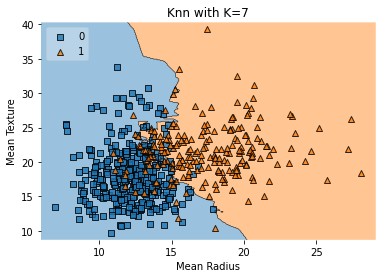

In [34]:
# Plot the decision area
from mlxtend.plotting import plot_decision_regions
def knn_comparison(k):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(mini_X, y)
# Plotting decision region
    plot_decision_regions(np.array(mini_X), np.array(y), clf=knn_model, legend=2)
# Adding axes annotations
    plt.xlabel('Mean Radius')
    plt.ylabel('Mean Texture')
    plt.title('Knn with K='+ str(k))
    plt.show()

knn_comparison(7)

# 7. K-fold cross validation

Cross-validation is a great tool when selecting a model or setting its parameters. Essentially, by using the average accuracy from the folds, one makes sure that the model doesn't perform well just because of the train-test split.

![CrossValidation.png](CrossValidation.png)

In [35]:
from sklearn.model_selection import cross_validate
results = cross_validate(
    KNeighborsClassifier(   # model specification
        n_neighbors = 7
    ),
    X,  # features
    y,  # labels
    cv = 5  # number of folds
)

print(results['test_score'])
print(f"Average accuracy: {round(results['test_score'].mean(), 4)*100}%")

[0.84210526 0.85087719 0.88596491 0.94736842 0.90265487]
Average accuracy: 88.58%
